### Imports

In [151]:
import torch
from torch import nn
from torch import Tensor
torch.cuda.is_available()

True

In [152]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd

In [153]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Dataset

In [154]:
# For linux users:
# !wget -O birds.tgz https://data.caltech.edu/records/65de6-vp158/files/CUB_200_2011.tgz?download=1
# !tar zxvf birds.tgz

In [155]:
IMG_SIZE=64
BATCH_SIZE=64
LATENT_DIM=100

In [156]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import cv2
# from tqdm import tqdm

class CustomDataset(Dataset):
    def __init__(self, annotations, bboxes, dataset_path, img_size):
        self.annotations = annotations
        self.bboxes = bboxes
        self.dataset_path = dataset_path
        self.img_size = img_size

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        image_id = self.annotations.iloc[idx]['id']
        image_path = self.annotations.iloc[idx]['path']
        bbox = self.bboxes[self.bboxes['id'] == image_id].iloc[0]

        img = cv2.imread(self.dataset_path + "images/" + image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img[bbox['y']:bbox['y'] + bbox['height'], bbox['x']:bbox['x'] + bbox['width'], :]
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = torch.tensor(img, dtype=torch.float32) / 127.5 - 1
        
        img = img.permute(2, 0, 1)

        return img

dataset_path = 'kaggle/CUB_200_2011/'

# Read txt files containing info about the bounding boxes and the file paths
bboxes = pd.read_csv(dataset_path + 'bounding_boxes.txt', sep=" ", names=["id", "x", "y", "width", "height"]).astype(int)
annotations = pd.read_csv(dataset_path + 'images.txt', sep=" ", names=["id", "path"])

# Create the dataset
custom_dataset = CustomDataset(annotations, bboxes, dataset_path, IMG_SIZE)

# Define the number of samples for training and testing
limit_training = len(custom_dataset) - 300
test = 300

# Split the dataset into training and testing
train_dataset, test_dataset = torch.utils.data.random_split(custom_dataset, [limit_training, test])

# Create DataLoader objects for training and testing
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(train_loader, test_loader)#store in array

<torch.utils.data.dataloader.DataLoader object at 0x7f4754300500> <torch.utils.data.dataloader.DataLoader object at 0x7f47541808f0>


## GAN Models

### Downsampling / Upsampling

In [157]:
class DownsampleBlock(nn.Module):
    def __init__(self, in_channels: int, filters: int, size: int, strides: int = 2, padding: str ='same', use_bn: bool = True) -> None:
        super().__init__()
        self.half_size = size // 2
        self.convolution = nn.Conv2d(in_channels, filters, kernel_size=size, stride=strides)
        self.use_bn = use_bn
        self.batchNorm = nn.BatchNorm2d(filters, momentum=0.5)
        self.activation = nn.LeakyReLU(negative_slope=0.2)
        
    
        
    def forward(self, x: torch.Tensor) -> Tensor:
        x = torch.nn.functional.pad(x, (self.half_size, self.half_size, self.half_size, self.half_size), mode='constant', value=0)
        x = self.convolution(x)
        if self.use_bn:
            x = self.batchNorm(x)
        x = self.activation(x)
        return x
    
class UpsampleBlock(nn.Module):
    def __init__(self, in_channels: int, filters: int, size: int, strides: int = 2, padding: str ='same', use_bn: bool = True) -> None:
        super().__init__()
        
        padding: int = size // 2
        output_padding: int = size % 2
        
        self.convolution = nn.ConvTranspose2d(in_channels, filters, kernel_size=size, stride=strides, padding=padding, output_padding=output_padding)
        self.use_bn = use_bn
        self.batchNorm = nn.BatchNorm2d(filters, momentum=0.5)
        self.activation = nn.ReLU()
        
    def forward(self, x: torch.Tensor) -> Tensor:
        x = self.convolution(x)
        if self.use_bn:
            x = self.batchNorm(x)
        x = self.activation(x)
        return x
        

### GAN Generator

In [158]:
class Generator(nn.Module):
    def __init__(self, input_size = LATENT_DIM) -> None:
        super().__init__()
        LINEAR_OUTPUT_SIZE = 4*4*256
        
        self.linear = nn.Linear(input_size, LINEAR_OUTPUT_SIZE)
        self.batchNorm = nn.BatchNorm1d(LINEAR_OUTPUT_SIZE)
        self.activation = nn.ReLU()
        self.upsampleBlock1 = UpsampleBlock(in_channels=256, filters=512, size=5)
        self.upsampleBlock2 = UpsampleBlock(in_channels=512, filters=256, size=5)
        self.upsampleBlock3 = UpsampleBlock(in_channels=256, filters=128, size=5)
        self.convTranspose2d = nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.last_activation = nn.Tanh()
        
    def forward(self, x: torch.Tensor) -> Tensor: 
        # x - wektor szumu
        x = self.linear(x)
        x = self.batchNorm(x)
        x = self.activation(x)
        x = x.view(-1, 256, 4, 4) #reshape -> channel 4x4 image
        x = self.upsampleBlock1(x)
        x = self.upsampleBlock2(x)
        x = self.upsampleBlock3(x)
        x = self.convTranspose2d(x)
        x = self.last_activation(x)
        return x

### GAN Discriminator

In [159]:
class Discriminator(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.downsampleBlock1 = DownsampleBlock(in_channels=3, filters=64, size=5, strides=2)
        self.downsampleBlock2 = DownsampleBlock(in_channels=64, filters=128, size=5, strides=2)
        self.downsampleBlock3 = DownsampleBlock(in_channels=128, filters=256, size=5, strides=2)
        self.dropout = nn.Dropout(0.4)
        self.dense = nn.Linear(256*8*8,1)
        self.activation = nn.Sigmoid()
        
    def forward(self, x: torch.Tensor) -> Tensor:
        x = self.downsampleBlock1(x)
        x = self.downsampleBlock2(x)
        x = self.downsampleBlock3(x)
        x = x.view(-1, 256*8*8)
        x = self.dropout(x)
        x = self.dense(x)
        x = self.activation(x)
        return x

# Learning

In [160]:
class GAN_trainer:
    def __init__(self, generator: nn.Module, discriminator: nn.Module, generator_optimizer: torch.optim.Optimizer,
                 discriminator_optimizer: torch.optim.Optimizer, dataloader: torch.utils.data.DataLoader) -> None:
        self.generator = generator
        self.discriminator = discriminator
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer
        self.loss = nn.BCELoss()
        self.dataloader = dataloader
        
    def train_discriminator_step(self):
        self.discriminator.zero_grad()
        
        real_images = next(iter(self.dataloader)).to(device)
        
        batch_size = real_images.shape[0]
        
        real_labels = torch.ones(batch_size, 1) - torch.rand(batch_size, 1) * 0.15
        fake_labels = torch.randn(batch_size, 1) * 0.15
        
        real_labels = real_labels.to(device)
        fake_labels = fake_labels.to(device)
        real_labels = real_labels.clamp(0.0, 1.0)
        fake_labels = fake_labels.clamp(0.0, 1.0)
        
        random_vectors = torch.randn(batch_size, LATENT_DIM).to(device)
        fake_images = self.generator(random_vectors)
        
        real_output = self.discriminator(real_images)
        fake_output = self.discriminator(fake_images)
        
        all_labels = torch.cat([real_labels, fake_labels], dim=0)
        all_output = torch.cat([real_output, fake_output], dim=0)
        
        loss = self.loss(all_output, all_labels)
        loss.backward()
        self.discriminator_optimizer.step()
        
        return loss
    
    def train_generator_step(self, batch_size = BATCH_SIZE):
        self.generator.zero_grad()
        
        random_vectors = torch.randn(batch_size, LATENT_DIM).to(device)
        fake_images = self.generator(random_vectors)
        
        fake_output = self.discriminator(fake_images)
        misleading_labels = torch.clamp(torch.ones(batch_size, 1) - torch.randn(batch_size, 1) * 0.15, 0.0, 1.0).to(device)
        loss = self.loss(fake_output, misleading_labels)
        
        loss.backward()
        self.generator_optimizer.step()
        
        return loss.item()

In [161]:
def visualize_batch(latent_batch: torch.Tensor, generator: nn.Module):
    generated_images = generator(latent_batch.to(device)).detach().cpu()
    fig, axs = plt.subplots(8, 8, figsize=(16, 16))
    for i in range(8):
        for j in range(8):
            numpy_image = ((generated_images[i*8+j] + 1.0) * 0.5).detach().numpy().transpose(1,2,0)
            axs[i, j].imshow(numpy_image)
            axs[i, j].axis('off')
    plt.show()
    
    
def visualize_batch_small(batch: torch.Tensor):
    batch_size = batch.shape[0]
    fig, axs = plt.subplots(1, batch_size, figsize=(16, 16))
    for i in range(batch_size):
        axs[i].imshow(((batch[i].permute(1, 2, 0) + 1.0) * 0.5).detach().cpu().numpy())
        axs[i].axis('off')
    plt.show()

# Instantiate and train the GAN

In [162]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

gan_trainer = GAN_trainer(generator, discriminator, torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999)),
                            torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999)), train_loader)

In [163]:
EPOCHS = 500

Epoch: 0, D_loss: 0.4490310549736023, G_loss: 2.6052024364471436


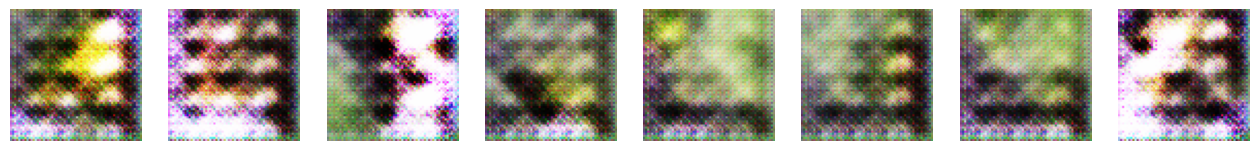

KeyboardInterrupt: 

In [165]:
for i in range(EPOCHS):
    for j in range(len(train_loader)):
        d_loss = gan_trainer.train_discriminator_step()
        g_loss = gan_trainer.train_generator_step()
    print(f"Epoch: {i}, D_loss: {d_loss}, G_loss: {g_loss}")
    
    if i % 5 == 0:
        visualize_batch_small(generator(torch.randn(8, LATENT_DIM).to(device)))